In [1]:
import numpy as np
import pandas as pd
import torch

from Plotting import Boxplots
from deprecated_Methods_fixed_window_size import aggCurves, Windowing

# Introduction
In this notebook we experiment with using less anchor points in each window. Before we took the entire window from the start until the last point.

We try two different approaches, both will have fixed window sizes to make it computationally more efficient. The idea behind these methods is that we don't need the entire window as a couple (mostly the last points) are more important.

The first approach is the naive version of sliding windows. This way we only take the last n points of the window. We will see that this works well for MDS but not as much for MMF. Reasoning is seen at the end of this notebook.

In the second approach we will uniformly take n anchor points over the window, the first and last points are always included. We will see that this works better for MMF and not as much for MDS.


# For use of windowing class

In [2]:
win = Windowing(aggCurves)
anchor_points = [16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896]
win.set_points(anchor_points, 5)

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [3]:
win.MDS()
win.MMF()

# Preprocessing

In [121]:
# Turn dataframe into numpy
learners = aggCurves['learner'].unique()
datasets = aggCurves['openmlid'].unique()
points = np.sort(aggCurves['size_train'].unique())

name = ['openmlid', 'learner', 'size_train']
multind = pd.MultiIndex.from_product([datasets,learners,points])

_ = aggCurves.set_index(name)
_ = _.reindex(multind)

# shape is [dataset,learner,point]
dataframe = _['score_test'].values.reshape(len(datasets), len(learners), len(points))

In [122]:
from numpy.lib.stride_tricks import sliding_window_view
anchor_points = [16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896]

window_size = 5
_anchor_points = np.array([anchor_points]).reshape(-1) # To get right shape
_train_anchors = np.copy(sliding_window_view(_anchor_points[:-1], window_size))
_train_anchors = np.einsum('ij->ji', _train_anchors)
_target_points = _anchor_points[window_size:]
s = len(_anchor_points)

# Grab the indices for numpy array
indices = np.where(np.in1d(points, _anchor_points))[0]

# Grab the segment values
segment = dataframe[...,indices]

# Split all possible windows and target points
# Use the sliding_window_view() function to create a view of the array with sliding windows
_target = segment[:,:,window_size:]
_data = np.copy(sliding_window_view(segment[:,:,:-1], window_size, axis = -1))
_data = np.einsum('ijkl -> ijlk',_data)

# method 2
endpoints = np.arange(window_size-1,len(_anchor_points)-1)
ind = np.ceil(np.linspace(0, endpoints, window_size)).astype(int)

_train_anchors2 = _anchor_points[ind]
_data2 = segment[:,:,ind]

# MDS and MMF with both types of windows

In [141]:
k = 4

data = np.copy(_data) # method 1
weights = (2 ** np.arange(window_size))[:, None]

# We have the following shape [new dataset, meta dataset, learner, (point on curve),... extra dims]scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
scalar = np.sum(weights * data[None] * data[:, None], axis=3) / np.sum(weights * (data ** 2), axis=2)[None]
adapted_curves = scalar[:, :, :, None] * data
adapted_target = scalar[..., None] * _target[..., None, :]
distance = np.sum((data - data[:, None]) ** 2, axis=3)
distance_adapted = np.sum((adapted_curves - data) ** 2, axis=3)

# Expand for next step
distance = np.repeat(distance[..., None], _target.shape[-1], axis=-1)
distance_adapted = np.repeat(distance_adapted[..., None], _target.shape[-1], axis=-1)

# Remove curves that can't predict at target
ind = np.isnan(_target).nonzero()
distance[:, ind[0], ind[1], ..., ind[2]] = np.nan
distance_adapted[:, ind[0], ind[1], ..., ind[2]] = np.nan

# So that it doesn't pick itself
np.einsum('ii...->i...', distance)[...] = np.nan
np.einsum('ii...->i...', distance_adapted)[...] = np.nan

# Take k closest
part_scale_after = np.argpartition(distance, k, axis=1)[:, :k]
part_scale_before = np.argpartition(distance_adapted, k, axis=1)[:, :k, ]
k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis=1)
k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis=1)

# Predicted target is just the mean of the k closest curves at the target point
prediction_scale_after = np.mean(k_closest_curves_scale_after, axis=1)
prediction_scale_before = np.mean(k_closest_curves_scale_before, axis=1)

# Remove predictions for anchor points that are in front of the window
ind = np.triu_indices(len(_target_points), 1)
prediction_scale_after[:, :, ind[1], ind[0]] = np.nan
prediction_scale_before[:, :, ind[1], ind[0]] = np.nan

errMDS1 = np.abs(prediction_scale_after - _target[:, :, None])

In [124]:
k = 4

data = np.copy(_data2) # method 2
weights = (2 ** np.arange(window_size))[:, None]

# We have the following shape [new dataset, meta dataset, learner, (point on curve),... extra dims]scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
scalar = np.sum(weights * data[None] * data[:, None], axis=3) / np.sum(weights * (data ** 2), axis=2)[None]
adapted_curves = scalar[:, :, :, None] * data
adapted_target = scalar[..., None] * _target[..., None, :]
distance = np.sum((data - data[:, None]) ** 2, axis=3)
distance_adapted = np.sum((adapted_curves - data) ** 2, axis=3)

# Expand for next step
distance = np.repeat(distance[..., None], _target.shape[-1], axis=-1)
distance_adapted = np.repeat(distance_adapted[..., None], _target.shape[-1], axis=-1)

# Remove curves that can't predict at target
ind = np.isnan(_target).nonzero()
distance[:, ind[0], ind[1], ..., ind[2]] = np.nan
distance_adapted[:, ind[0], ind[1], ..., ind[2]] = np.nan

# So that it doesn't pick itself
np.einsum('ii...->i...', distance)[...] = np.nan
np.einsum('ii...->i...', distance_adapted)[...] = np.nan

# Take k closest
part_scale_after = np.argpartition(distance, k, axis=1)[:, :k]
part_scale_before = np.argpartition(distance_adapted, k, axis=1)[:, :k, ]
k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis=1)
k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis=1)

# Predicted target is just the mean of the k closest curves at the target point
prediction_scale_after = np.mean(k_closest_curves_scale_after, axis=1)
prediction_scale_before = np.mean(k_closest_curves_scale_before, axis=1)

# Remove predictions for anchor points that are in front of the window
ind = np.triu_indices(len(_target_points), 1)
prediction_scale_after[:, :, ind[1], ind[0]] = np.nan
prediction_scale_before[:, :, ind[1], ind[0]] = np.nan

errMDS2 = np.abs(prediction_scale_after - _target[:, :, None])

In [223]:

'''
Applies MMF algorithm. Tensorized with pytorch so that it calculates quickly
'''

# Tensorise variables
target = torch.tensor(_target, dtype=torch.float32)
data = torch.tensor(_data, dtype=torch.float32) # method 1
train_anchors = torch.tensor(_train_anchors, dtype=torch.float32) # method 1
weights = (2**torch.arange(window_size))[:,None]
params = torch.tensor([0.5,1,1,-1], dtype=torch.float32)
shp = np.hstack((np.array(data.shape[:2]),np.array(data.shape[3])))

params = params.repeat(*shp,1)[:,:,None] # since len(dim[2]) = len(dim[3])

params.requires_grad_()
gr = torch.ones(*shp) # For .backward(), usually only takes a scalar but with this it doesn't need  to
# Func to optimise

def mmf_func(beta,x):
  return (beta[...,0] * beta[...,1] + beta[...,2] * x ** beta[...,3])/(beta[...,1] + x ** beta[...,3])
optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
y = data
nan = torch.isnan(y)
y = torch.where(nan, torch.tensor(0.0), y)

steps = 500

loss1 = []
out1 = []
par1 = []
for i in range(steps):
  optimizer.zero_grad()
  # Sum over last dimension
  out = mmf_func(params,train_anchors)
  out = torch.where(nan, torch.tensor(0.0), out)
  out1.append(out[...,0].detach().numpy())
  loss = (((out - y) ** 2)*weights).sum(2)
  loss1.append(loss[...,0].detach().numpy())
  # Each curve has separate .backward() with this
  loss.backward(gradient = gr)
  optimizer.step()
  par1.append(params[...,0,:].detach().numpy())

params.requires_grad = False # To not waste computation
target_points = torch.tensor(_target_points, dtype=torch.float32)[:,None]
prediction = mmf_func(params,target_points)

# Remove predictions for anchor points that are in front of the window
ind = torch.triu_indices(len(target_points),len(target_points),1)
prediction[:,:,ind[0],ind[1]] = torch.nan
prediction = torch.einsum('ijkl->ijlk',prediction)

errMMF1 = (prediction - target[:,:,None]).abs().numpy()

In [224]:

'''
Applies MMF algorithm. Tensorized with pytorch so that it calculates quickly
'''

# Tensorise variables
target = torch.tensor(_target, dtype=torch.float32)
data = torch.tensor(_data2, dtype=torch.float32) # method 2
train_anchors = torch.tensor(_train_anchors2, dtype=torch.float32) # method 2
weights = (2**torch.arange(window_size))[:,None]
params = torch.tensor([0.5,1,1,-1], dtype=torch.float32)
shp = np.hstack((np.array(data.shape[:2]),np.array(data.shape[3])))

params = params.repeat(*shp,1)[:,:,None] # since len(dim[2]) = len(dim[3])

params.requires_grad_()
gr = torch.ones(*shp) # For .backward(), usually only takes a scalar but with this it doesn't need  to
# Func to optimise

def mmf_func(beta,x):
  return (beta[...,0] * beta[...,1] + beta[...,2] * x ** beta[...,3])/(beta[...,1] + x ** beta[...,3])
optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
y = data
nan = torch.isnan(y)
y = torch.where(nan, torch.tensor(0.0), y)

steps = 500

out2 = []
loss2 = []
par2 = []
for i in range(steps):
  optimizer.zero_grad()
  # Sum over last dimension
  out = mmf_func(params,train_anchors)
  out = torch.where(nan, torch.tensor(0.0), out)
  out2.append(out[...,0].detach().numpy())
  loss = (((out - y) ** 2)*weights).sum(2)
  loss2.append(loss[...,0].detach().numpy())
  # Each curve has separate .backward() with this
  loss.backward(gradient = gr)
  optimizer.step()
  par2.append(params[...,0,:].detach().numpy())

params.requires_grad = False # To not waste computation
target_points = torch.tensor(_target_points, dtype=torch.float32)[:,None]
prediction = mmf_func(params,target_points)

# Remove predictions for anchor points that are in front of the window
ind = torch.triu_indices(len(target_points),len(target_points),1)
prediction[:,:,ind[0],ind[1]] = torch.nan
prediction = torch.einsum('ijkl->ijlk',prediction)

errMMF2 = (prediction - target[:,:,None]).abs().numpy()

# Full window method

In [127]:
window_points = [16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048]
target_points =[2896]

windows = True
window_points = np.array([window_points]).reshape(-1) # To get right shape
target_points = np.array([target_points]).reshape(-1)
anchor_points = np.hstack((window_points,target_points[:-1]))
s = len(anchor_points)



# Grab the indices for numpy array
indices_window = np.where(np.in1d(points, window_points))[0]
indices_target = np.where(np.in1d(points, target_points))[0]

# Grab the segment and the target values
segment = dataframe[...,np.hstack((indices_window,indices_target[:-1]))]
target = dataframe[...,indices_target]

if windows:
  # Make all the windows, another dimension is added at the end for this [..., window]
  data = np.repeat(segment[...,None],segment.shape[2],-1)
  triu = np.triu_indices(segment.shape[2],1)
  data[...,triu[1],triu[0]] = np.nan


In [128]:
k = 4
'''
Applies MDS algorithm on all windows to retrieve the regression predictions.
Saves the absolute error in the prediction. Also saves MDS version where you
scale /adapt curves before picking them. Original version scales after picking
'''
data = np.copy(data)
data[...,triu[1],triu[0]] = 0
# weights = np.arange(1, self.s + 1) ** 2
weights = (2**np.arange(s))[:,None]

# We have the following shape [new dataset, meta dataset, learner, (point on curve),... extra dims]
scalar = np.sum(weights * data[None]*data[:,None], axis = 3) / np.sum(weights*(data**2), axis = 2)[None]
adapted_curves = scalar[:,:,:,None]*data
adapted_target = scalar[...,None]*target[...,None,:]
distance = np.sum((data-data[:,None])**2,axis = 3)
distance_adapted = np.sum((adapted_curves - data)**2,axis = 3)

distance = np.repeat(distance[...,None],len(target_points),axis = -1)
distance_adapted = np.repeat(distance_adapted[...,None],len(target_points),axis = -1)

# Remove curves that can't predict at target
ind = np.isnan(target).nonzero()
distance[:,ind[0],ind[1],...,ind[2]] = np.nan
distance_adapted[:,ind[0],ind[1],...,ind[2]] = np.nan

# So that it doesn't pick itself
np.einsum('ii...->i...',distance)[...] = np.nan
np.einsum('ii...->i...',distance_adapted)[...] = np.nan

# Take k closest
part_scale_after = np.argpartition(distance, k, axis = 1)[:,:k]
part_scale_before = np.argpartition(distance_adapted, k, axis = 1)[:,:k,]
k_closest_curves_scale_after = np.take_along_axis(adapted_target, part_scale_after, axis = 1)
k_closest_curves_scale_before = np.take_along_axis(adapted_target, part_scale_before, axis = 1)

# Predicted target is just the mean of the k closest curves at the target point
prediction_scale_after = np.mean(k_closest_curves_scale_after,axis = 1)
prediction_scale_before = np.mean(k_closest_curves_scale_before,axis = 1)

target = np.copy(target)
if windows:
  target = target[:,:,None]


test_error_MDS = np.abs(prediction_scale_after - target)

In [129]:
window_points = [16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048]
target_points =[2896]

windows = True
window_points = np.array([window_points]).reshape(-1) # To get right shape
target_points = np.array([target_points]).reshape(-1)
anchor_points = np.hstack((window_points,target_points[:-1]))
s = len(anchor_points)



# Grab the indices for numpy array
indices_window = np.where(np.in1d(points, window_points))[0]
indices_target = np.where(np.in1d(points, target_points))[0]

# Grab the segment and the target values
segment = dataframe[...,np.hstack((indices_window,indices_target[:-1]))]
target = dataframe[...,indices_target]

if windows:
  # Make all the windows, another dimension is added at the end for this [..., window]
  data = np.repeat(segment[...,None],segment.shape[2],-1)
  triu = np.triu_indices(segment.shape[2],1)
  data[...,triu[1],triu[0]] = np.nan


In [130]:

steps = 500
'''
Applies MMF algorithm. Tensorized with pytorch so that it calculates quickly
'''

# Tensorise variables
target = torch.tensor(target, dtype=torch.float32)
data = torch.tensor(data, dtype=torch.float32)
anchor_points = torch.tensor(anchor_points, dtype=torch.float32)
weights = (2**torch.arange(s))[:,None]
params = torch.tensor([0.5,1,1,-1], dtype=torch.float32)
shp = np.hstack((np.array(data.shape[:2]),np.array(data.shape[3])))

params = params.repeat(*shp,1)[:,:,None] # since len(dim[2]) = len(dim[3])

params.requires_grad_()
gr = torch.ones(*shp) # For .backward(), usually only takes a scalar but with this it doesn't need  to
# Func to optimise

def mmf_func(beta,x):
  x = x[:,None]
  return (beta[...,0] * beta[...,1] + beta[...,2] * x ** beta[...,3])/(beta[...,1] + x ** beta[...,3])
optimizer = torch.optim.Adam([params], lr=0.1) # SGD did weird things, Adam works well!
y = data
nan = torch.isnan(y)
y = torch.where(nan, torch.tensor(0.0), y)

for i in range(steps):
  optimizer.zero_grad()
  # Sum over last dim, watch out with nan's maybe?
  out = mmf_func(params,anchor_points)
  out = torch.where(nan, torch.tensor(0.0), out)
  loss = (((out - y) ** 2)*weights).sum(2)
  # Each curve has separate .backward() with this
  loss.backward(gradient = gr)
  optimizer.step()

params.requires_grad = False # To not waste computation
target_points = torch.tensor(target_points, dtype=torch.float32)
prediction = mmf_func(params,target_points)

if windows:
  prediction = torch.einsum('...ij -> ...ji', prediction)
  target = target[:,:,None]

test_error_MMF = (target - prediction).abs().numpy()

# Experiments

In [131]:
np.allclose(_data2[:,:,:,0], _data[:,:,:,0], equal_nan=True)

True

In [159]:
print(np.allclose(test_error_MMF[:,:,4,0],errMMF1[:,:,0,-1], equal_nan=True))
print(np.allclose(test_error_MMF[:,:,4,0],errMMF2[:,:,0,-1], equal_nan=True))
print(np.allclose(errMDS1[:,:,0,-1],test_error_MDS[:,:,4,0],equal_nan=True))
print(np.allclose(errMDS2[:,:,0,-1],test_error_MDS[:,:,4,0],equal_nan=True))
# Probably because of the randomness in MMF from gradient descent, since it does make the same for MDS

True
False
True
True


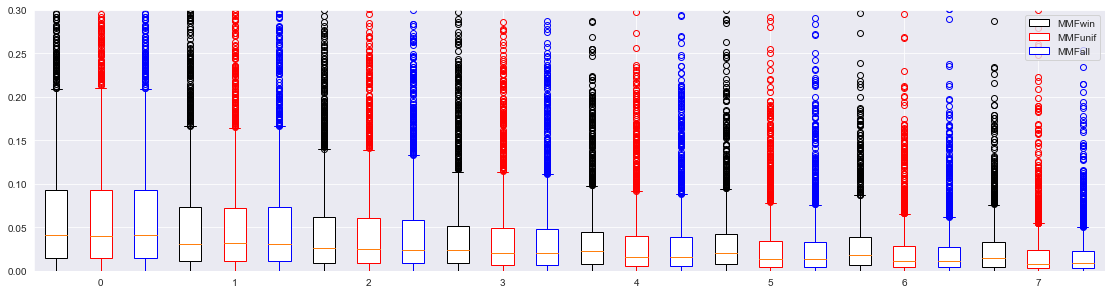

In [154]:
plots = {'MMFwin': {str(i): errMMF1[:,:,i,-1] for i in range(8)}, 'MMFunif': {str(i): errMMF2[:,:,i,-1] for i in range(8)},
  'MMFall': {str(i): test_error_MMF[:,:,i+4,0] for i in range(8)}}

Boxplots(plots, ylim=[0,0.3], figsize=(3,1))

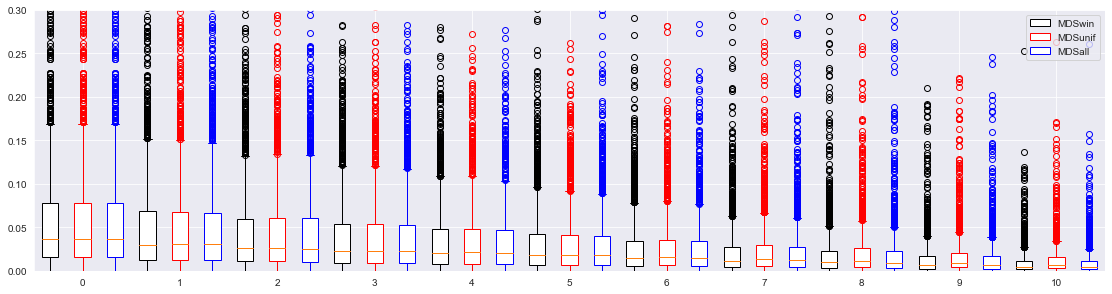

In [155]:
plots = {'MDSwin': {str(i): errMDS1[:,:,i,-1] for i in range(11)}, 'MDSunif': {str(i): errMDS2[:,:,i,-1] for i in range(11)},
         'MDSall': {str(i): test_error_MDS[:,:,i+4,0] for i in range(11)}}

Boxplots(plots, ylim=[0,0.3], figsize=(3,1))

This makes sense, MMF works better with more uniformly distributed as the more spread points the better it can see the overall shape of the curve.

MDS on the other hand works better with just the last points since it's a knn algorithm and only cares about the last point in the neighbors (so similar last points means similar overall last neighbor).

We check the randomness of gradient descent:

In [225]:
loss1 = np.array(loss1)
loss2 = np.array(loss2)
out1 = np.array(out1)
out2 = np.array(out2)
par1 = np.array(par1)
par2 = np.array(par2)

In [226]:
par1[0]

array([[[[ 1.0538596 ,  0.57258326, -0.46848187, -0.6082637 ]],

        [[ 1.0876726 ,  0.55686057, -0.48136473, -0.57795644]],

        [[ 1.0219624 ,  0.50199944, -0.7887807 , -0.6273223 ]],

        ...,

        [[ 1.0258576 ,  0.6884446 , -0.40408728, -0.46098712]],

        [[ 0.5       ,  1.        ,  1.        , -1.        ]],

        [[ 0.5       ,  1.        ,  1.        , -1.        ]]],


       [[[ 0.43338963,  0.78625476, -0.9315621 , -0.58011156]],

        [[ 0.6493111 ,  0.5546173 , -1.08715   , -0.5110262 ]],

        [[ 0.33930728,  0.9813331 , -0.98412454, -0.487933  ]],

        ...,

        [[ 0.32510594,  1.0170863 , -0.9880089 , -0.5296019 ]],

        [[ 0.8828157 ,  0.41338935, -1.3822645 , -0.5176047 ]],

        [[ 0.5       ,  1.        ,  1.        , -1.        ]]],


       [[[ 0.90038365,  1.0496042 , -0.0557899 , -0.85979617]],

        [[ 1.0761352 ,  0.67071867, -0.35478315, -0.5150184 ]],

        [[ 0.89621013,  0.9203839 , -0.20602913, -0.708547

In [232]:
par2[0]

array([[[[ 1.0551428 ,  0.57317257, -0.46551487, -0.6057734 ]],

        [[ 1.0719012 ,  0.578907  , -0.49119985, -0.5952361 ]],

        [[ 1.0219715 ,  0.5019831 , -0.7887186 , -0.6273112 ]],

        ...,

        [[ 1.0433667 ,  0.680598  , -0.37736905, -0.44868338]],

        [[ 0.5       ,  1.        ,  1.        , -1.        ]],

        [[ 0.5       ,  1.        ,  1.        , -1.        ]]],


       [[[ 0.4065409 ,  0.8102844 , -0.9562782 , -0.61938506]],

        [[ 0.6422548 ,  0.5600446 , -1.1044216 , -0.51710975]],

        [[ 0.3393104 ,  0.9812848 , -0.9841277 , -0.4878868 ]],

        ...,

        [[ 0.3246817 ,  1.018496  , -0.98752594, -0.5305037 ]],

        [[ 0.8248698 ,  0.44562083, -1.5171615 , -0.5468511 ]],

        [[ 0.5       ,  1.        ,  1.        , -1.        ]]],


       [[[ 0.9003837 ,  1.0496044 , -0.05578988, -0.85979605]],

        [[ 1.0874211 ,  0.66797256, -0.3347576 , -0.49977642]],

        [[ 0.8962101 ,  0.9203855 , -0.20602919, -0.708546

In [237]:
print(np.allclose(out1[0],out2[0], equal_nan=True))
print(np.allclose(loss1[0],loss2[0], equal_nan=True))
print(np.allclose(par1[0],par2[0], equal_nan=True))

# Eventhough we have same loss and output for the 0th window, the parameter update happens differently (0 is after 1st update with out[0] and loss[0])

True
True
False
